In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from math import log10
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from astropy.table import Table
from astropy.cosmology import Planck13
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
%matplotlib inline

# Read data

In [15]:
cat="../Nair_Abraham_cat.fit"
data=fits.getdata(cat,1)
t=Table(data)
print(t)
print(t.colnames)

     dr7objid              SDSS            RA   ... tails   RC3     Tt_2  
------------------ -------------------- ------- ... ----- ------- --------
587748927626149924 J112408.63-010927.83 171.036 ...   0.0 .LXR0..      2.0
587748927626870899 J113057.91-010851.06 172.742 ...   0.0 999999       0.5
587748927627722875 J113833.27-011104.16 174.639 ...   0.0 .SXR2?.      3.5
587722981742084144 J121808.55-010350.82 184.536 ...   0.0 .SXT4..      3.5
587722981744640177 J124159.07-011043.98 190.497 ...   0.0 PSBS2..      3.0
587722981744771128 J124257.26-011345.93 190.739 ...   0.0 .SAS6*/      4.5
587722981745295552 J124752.98-011109.04 191.971 ...   0.0 .S..7*/      4.0
587722981745426489 J124859.91-010935.43  192.25 ...   0.0 999999       1.5
587722981747392587 J130705.63-011036.63 196.774 ...   0.0 999999       4.0
587722981748048006 J131236.98-011151.02 198.155 ...   0.0 999999       3.5
               ...                  ...     ... ...   ...     ...      ...
587738568708980870 J13114

# Define feautures and labels

In [16]:


#define feature to use
nf=2
f1=data['g-r'] #color
f2=data['n_r'] #Sersic index

#define two classes (early/late)
ttype=data["TType"]
m=ttype*0-1
m[np.where((ttype>0) & ((ttype<=10)))]=1
m[np.where((ttype<=0) & ((ttype>=-5)))]=0


#remove bad values
p=np.where((f1>-1) & (f1<2) & (f2>0) & (f2<6) & (m>=0))


#target vector
label_vector=m[p]

#feature vector
feature_vector=np.zeros((label_vector.shape[0],2))
feature_vector[:,0]=f1[p]
feature_vector[:,1]=f2[p]


#divide test/train datasets
X_train, X_test, y_train, y_test = train_test_split(feature_vector, label_vector, test_size=0.33, random_state=42)
print("Sizes training / test")
print(X_train.shape)
print(X_test.shape)

Sizes training / test
(7975, 2)
(3928, 2)


# Plot featues histograms

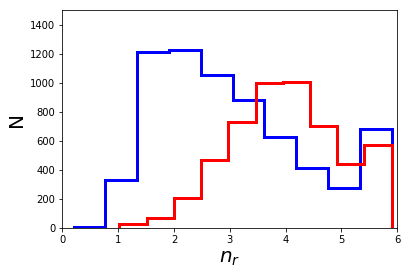

(array([1.000e+00, 1.000e+00, 2.000e+00, 1.200e+01, 3.800e+01, 1.440e+02,
        5.710e+02, 3.558e+03, 8.750e+02, 6.000e+00]),
 array([0.064 , 0.1551, 0.2462, 0.3373, 0.4284, 0.5195, 0.6106, 0.7017,
        0.7928, 0.8839, 0.975 ]),
 <a list of 1 Patch objects>)

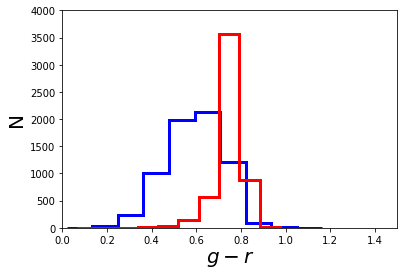

In [17]:
plt.xlabel("$n_r$", fontsize=20)
plt.ylabel("N", fontsize=20)
plt.xlim(0,6)
plt.ylim(0,1500)
plt.hist(feature_vector[label_vector==1,1],histtype='step',color='blue',linewidth=3)
plt.hist(feature_vector[label_vector==0,1],histtype='step',color='red',linewidth=3)
plt.show()
plt.xlabel("$g-r$", fontsize=20)
plt.ylabel("N", fontsize=20)
plt.xlim(0,1.5)
plt.ylim(0,4000)
plt.hist(feature_vector[label_vector==1,0],histtype='step',color='blue',linewidth=3)
plt.hist(feature_vector[label_vector==0,0],histtype='step',color='red',linewidth=3)

# Plot feature space

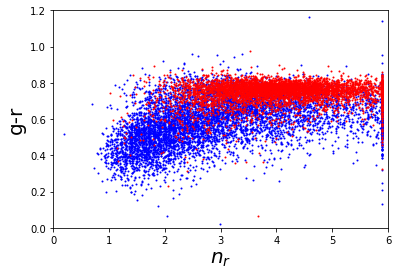

In [18]:
plt.xlabel("$n_r$", fontsize=20)
plt.ylabel("g-r", fontsize=20)
plt.xlim(0,6)
plt.ylim(0,1.2)
plt.scatter(feature_vector[label_vector==1,1],feature_vector[label_vector==1,0],color='blue',s=1)
plt.scatter(feature_vector[label_vector==0,1],feature_vector[label_vector==0,0],color='red',s=1)

# Train

In [19]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print("Trained RF Classifier")
print(clf)
print("Importance of each feature")
print(clf.feature_importances_)

Trained RF Classifier
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Importance of each feature
[0.51027257 0.48972743]


# Test

auc:  0.8873346291287059


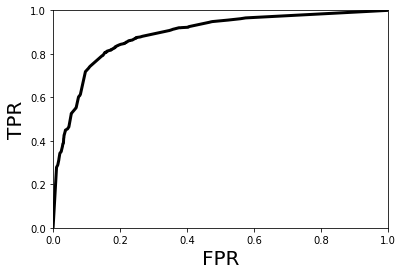

In [20]:
y_pred=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])

#plot ROC
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(fpr,tpr,linewidth=3,color='black')
print("auc: ", auc(fpr, tpr))

# Visualize tree [optional]

In [12]:
i_tree = 0
for tree_in_forest in clf.estimators_:
    with open("/Users/marchuertascompany/Documents/teaching/big_data_ED/RF_ML.dot", "w") as f:
        f = export_graphviz(tree_in_forest, out_file=f)
    i_tree = i_tree + 1    
os.system('dot -Tpng /Users/marchuertascompany/Documents/teaching/big_data_ED/RF_ML.dot -o /Users/marchuertascompany/Documents/teaching/big_data_ED/RF_ML.png')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/marchuertascompany/Documents/teaching/big_data_ED/RF_ML.dot'